## Outline

- Dataset from the competition of our choice 
  - Understand the problem and the evaluation metric used
- Setup fastai, Config to store the constants and imports
- Download the data
- Cleaning 
- Understand the structure of the data in order to setup the datablock
  - data is balanced or imbalanced
  - where to fetch the data from
  - train-test split, with stratify or cross-validation(kfold, stratifiedKFold) 
  - decide if preprocessing is required
  - decide on the tokenization(or subword)
  - debugging help

- Post DataBlock setup
  - check the one-batch
  - check the summary

- Language Model
  - Add Mixed Precision Training
  - AWD_LSTM
  - integrate callbacks for weights and biases
  - train the language model using discriminative learning rates
  - save the encoder

- Classification Model
  - use the vocab from language model dataloaders
  - use the encoder on the learner
  - train the model
  - gradual unfreezing

- Future 
  - How to extend it further(by making it public - add Tendo's share here)
  - add pratik and amit's on structuring the project 
  
  
- Questions/Reference
  - how to train a backward language model
  - how to combine forward and backward language model
  - How to incorporate blurr along with fastai
  - Text Interpretation https://muellerzr.github.io/fastinference/text.inference/
  - Captum for text interpretation
  - Discriminative Learning Rate https://harish3110.github.io/through-tinted-lenses/natural%20language%20processing/sentiment%20analysis/2020/06/27/Introduction-to-NLP-using-Fastai.html#Discriminative-Fine-tuning  
  - https://github.com/muellerzr/Practical-Deep-Learning-For-Coders/blob/master/05a_NLP.ipynb
  - Mixup for AWD_LSTM https://github.com/fmcurti/MixUp-for-AWD_LSTM/blob/master/ULMFiT.ipynb

In [ ]:
%%capture
!pip install git+https://github.com/fastai/fastai2.git -q
!pip install git+https://github.com/fastai/fastcore.git -q

!pip install -q nbdev
!pip install -q azure-cognitiveservices-search-imagesearch sentencepiece

# Upload utils.py from fastai repository
!wget https://raw.githubusercontent.com/fastai/fastbook/master/utils.py

In [ ]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/data/vaccination_tweet"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from fastai2.text.all import *

In [ ]:
c = Config()
c['data_path'] = f'{drive_data}'
c['model_path'] = f'{drive_data}/models'
c['bs'] = 128
c['seq_len'] = 72
c.d

{'archive_path': '/root/.fastai/archive',
 'bs': '128',
 'data_path': '/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet',
 'model_path': '/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/models',
 'seq_len': '72',
 'storage_path': '/root/.fastai/data',
 'version': 2}

In [ ]:
vaccination = Path(c.d['data_path']);
train_df = pd.read_csv(vaccination/'Train.csv')
test_df = pd.read_csv(vaccination/'Test.csv')
len(train_df), len(test_df)

(10001, 5177)

In [ ]:
train_df.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

In [ ]:
train_df.dropna(axis='rows', inplace=True);len(train_df)

9999

In [ ]:
#train_df.fillna(value=' ', inplace=True)
test_df.fillna(value=' ', inplace=True)

## DataLoaders

In [ ]:
doc(SentencePieceTokenizer)

In [ ]:
tweet_lm = DataBlock(
            blocks=TextBlock.from_df(text_cols='safe_text', is_lm=True, tok_func=SentencePieceTokenizer, model_type='bpe', max_vocab_sz=10000),
            get_x=ColReader('text'),
            splitter=RandomSplitter(valid_pct=0.15, seed=42)
            )

In [ ]:
df = pd.concat([train_df, test_df])

In [ ]:
dls = tweet_lm.dataloaders(source=df, bs=int(c.d['bs']), seq_len=int(c.d['seq_len']))

In [ ]:
len(dls.vocab)

6216

## Language Learner

In [ ]:
doc(language_model_learner)

In [ ]:
learn_lm = language_model_learner(dls, arch=AWD_LSTM, drop_mult=0.3, pretrained=True, metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.013182567432522774)

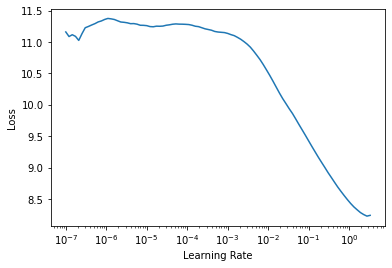

In [ ]:
learn_lm.lr_find()

In [ ]:
lm_lr = 1e-2

In [ ]:
learn_lm.fine_tune(8, base_lr=lm_lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.731276,5.721750,0.173679,305.439056,00:29


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.676833,5.327257,0.207547,205.872421,00:31
1,5.365718,4.827284,0.255697,124.871391,00:31
2,5.025544,4.518177,0.286770,91.668335,00:31
3,4.728319,4.355146,0.300401,77.878227,00:31
4,4.496605,4.251612,0.311808,70.218529,00:31
5,4.332778,4.201892,0.317858,66.812614,00:31
6,4.213473,4.182868,0.320936,65.553589,00:31
7,4.144303,4.179251,0.321221,65.316925,00:31


In [ ]:
learn_lm.save('8_1e-2_lm_fine_tuned')

In [ ]:
MODEL_PATH = c.d['model_path']

In [ ]:
learn_lm.save_encoder('8_1e-2_lm_fine_tuned_enc')

In [ ]:
#learn_lm.save_encoder(f'{MODEL_PATH}/8_1e-2_lm_bpe_fine_tuned_enc')

## Regression

In [ ]:
tweet_cls = DataBlock(blocks=[TextBlock.from_df(text_cols='safe_text', vocab=dls.vocab, tok_func=SentencePieceTokenizer, model_type='bpe', max_vocab_sz=10000),
                              RegressionBlock],
                      get_x=ColReader(cols='text'),
                      get_y=ColReader(cols='label'),
                      splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [ ]:
tweet_cls_dls = tweet_cls.dataloaders(source=train_df,verbose=True,
                                      bs=int(c.d['bs']),
                                      seq_len=int(c.d['seq_len']))

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 


In [ ]:
tweet_cls_dls.show_batch(max_n=3)

,text,text_
0,▁xxbos ▁ xxunk xxunk xxunk xxunk xxunk xxunk の に mmr xxunk xxunk xxunk xxunk の xxunk xxunk xxunk xxunk xxunk た xxunk $ 550 の xxunk xxunk xxunk xxunk た 。 ▁xxrep ▁4 ▁( ▁; xxunk д xxunk ▁xxrep ▁7 ▁ ) ▁ xxunk xxunk xxunk xxunk xxunk xxunk xxunk に xxunk xxunk し xxunk xxunk xxunk xxunk xxunk た 。 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 。,0.0
1,▁xxbos ▁... в к о л о л и ▁ т у т ▁ м н е ▁xxup ▁mmr - п р и в и в к у ▁... ▁( measles - mumps - r ub ella ▁vaccine ) ▁.... ▁ в ▁ xxunk у д у xxunk е е ▁ с м о т р ю ▁ с ▁ о п т и м и з м о м ▁...,0.0
2,▁xxbos ▁xxmaj ▁the ▁xxup ▁mmr ▁mo ds p ace ▁xxup ▁m x - 5 ▁team ▁on ▁the ▁gr id ▁for ▁the ▁second ▁xxmaj ▁b atter y ▁xxmaj ▁tend er ▁race ▁at ▁xxmaj ▁se br ing ! ▁# ▁xxmaj ▁se br ing ▁# ▁mo ds p ace ▁# ▁ma z da ▁# ▁m x 5 c up ▁# ▁global m x 5 c up ▁# ▁sc ca,0.0


In [ ]:
doc(text_classifier_learner)

In [ ]:
learn_cls = text_classifier_learner(dls=tweet_cls_dls,
                                    arch=AWD_LSTM,
                                    loss_func=mse,                                    
                                    metrics=rmse,
                                    y_range=[-1, 1])

In [ ]:
learn_cls.load_encoder(f'8_1e-2_lm_fine_tuned_enc')

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=5.754399353463668e-06)

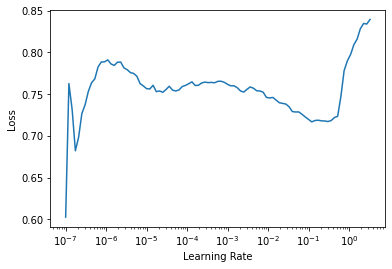

In [ ]:
learn_cls.lr_find()

In [ ]:
learn_cls.fine_tune(epochs=8, base_lr=1e-2)

epoch,train_loss,valid_loss,_rmse,time
0,0.655240,0.384711,0.620251,00:16


epoch,train_loss,valid_loss,_rmse,time
0,0.479516,0.387409,0.622422,00:17
1,0.405052,0.344687,0.587101,00:17
2,0.378217,0.357070,0.597553,00:17
3,0.359391,0.340642,0.583646,00:17
4,0.347887,0.340789,0.583771,00:17
5,0.335765,0.327030,0.571865,00:17
6,0.322824,0.326958,0.571802,00:17
7,0.312481,0.327277,0.572081,00:17


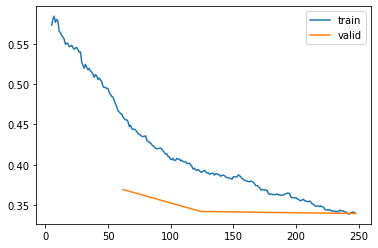

In [ ]:
learn_cls.recorder.plot_loss()

## Inference - **NOT WORKING**

In [ ]:
test_df.rename(columns={'safe_text': 'text'}, inplace=True)

In [ ]:
len(test_df)

5177

In [ ]:
test_df

,tweet_id,text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to crime. #SVU"
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>"
...,...,...
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her kids and give us all goddamn polio??
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time since 2011 <url>
5174,ZYITEHAH,"<user> issues alert regarding Measles in TX. Keep your DDx up to date, people! #Emergencymedicine"
5175,ZZ3BMBTG,I can't believe people don't vaccinate their kids! I've been vaccinated for everything and then some.


In [ ]:
sent_tfm = Tokenizer.from_df(text_cols='text', 
                             tok_func=SentencePieceTokenizer,
                             model_type='bpe',
                             max_vocab_sz=10000)

In [ ]:
tfms = [attrgetter('text'), sent_tfm, Numericalize()]

In [ ]:
doc(Datasets)

In [ ]:
test_dset = Datasets(items=test_df, tfms=[tfms], splits=None, dl_type=)

In [ ]:
test_dl = test_dset.dataloaders(bs=int(c.d['bs']), seq_len=int(c.d['seq_len']))

In [ ]:
learn_cls.dls.test_dl = test_dl

In [ ]:
predictions, _, targets = learn_cls.get_preds(dl=test_dl, with_decoded=True)

IndexError: ignored

In [ ]:
targets

tensor([[-0.6514],
        [ 0.5469],
        [ 0.2638],
        ...,
        [ 0.2053],
        [ 0.9290],
        [ 0.6997]])

In [ ]:
vaccination.ls()

(#4) [Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/SampleSubmission.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/Train.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/Test.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/models')]

In [ ]:
submission = pd.read_csv(vaccination/'SampleSubmission.csv')

In [ ]:
submission.head()

,tweet_id,label
0,00BHHHP1,0
1,00UNMD0E,0
2,01AXPTJF,0
3,01HOEQJW,0
4,01JUKMAO,0


In [ ]:
len(submission), len(predictions)

(5177, 5177)

In [ ]:
submission['label'] = predictions.flatten()

In [ ]:
submission

,tweet_id,label
0,00BHHHP1,-0.651409
1,00UNMD0E,0.546905
2,01AXPTJF,0.263799
3,01HOEQJW,0.988286
4,01JUKMAO,0.055132
...,...,...
5172,ZXVVNC5O,0.890525
5173,ZYIANVI8,0.190089
5174,ZYITEHAH,0.205295
5175,ZZ3BMBTG,0.928989


In [ ]:
submission.to_csv('submission.csv', index=False)